<a href="https://colab.research.google.com/github/evandwh/Data-Viz-Portfolio/blob/main/ST554_Project_1_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ST554 Project 1: Task 3

Authored by: Evan Whitfield

Collaborators: Jamie Loring

##Intro

In this report, we will be investing how the Benzene concentration (`C6H6(GT)`) in the air  may be predicted using various other variables. The main other variable that we will be investigating is the Carbon Monoxide concentration (`CO(GT)`) in the air. Temperature (`T`), Relative Humidity (`RH`) and Absolute Humidity (`AH`) will be the other three variables of interest.

For a given location, measurements about the air quality were taken and the time and day of the meausurements were also recorded. This happened over a 13 month span between March 2004 to April 2005. Not every day had usuable recordings. We did not investigate the cause of any missing data. We ignored missing values to conduct an investigation on the recorded values in the data set.


##Data and Module Importing

In order to get the data we will fit the models to, we need to install the correct repo below.

In [45]:
!pip install ucimlrepo

Now that the repo is installed, we need to import all of the modules needed to do our model fitting.

In [46]:
import ucimlrepo as uci
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import linear_model


Next, we will make sure that we fetch the correct data from the repo, and take a look at the data we will be working with. There are many variables that will not be used.

The main variables we will be examining are `Date`, `CO(GT)`, `C6H6(GT)`,`T`,`RH`, and `AH`.

Here is a description of all the variables:

“True” (or gold standard) measurements of pollutants in the air
*   CO(GT) (CO concentration)
*   NMHC(GT) (Non Metanic HydroCarbon concentration)
*   C6H6(GT) (Benzene concentration)
*   NOx(GT) (NOx concentration)
*   NO2(GT) (NO2 concentration)

Sensor measurements of pollutants in the air (not used in our data study).

*   PT08.S1(CO)
*   PT08.S2(NMHC)
*   PT08.S3(NOx)
*   PT08.S4(NO2)
*   PT08.S5(O3)

Weather related measurements
*   T (temperature)
*   RH (Relative humidity)
*   AH (Absolute humidity)

*Note: All true and sensor measurement variable values are hourly averages*



In [47]:
air_quality = uci.fetch_ucirepo(id=360)

air_quality.data.features

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


##Data Cleaning

For the purpose of this study, we will save the data as a usuable dataframe but ignore any entry that is missing values for the variables we are studying.

We were left with 7344 data entries.

In [48]:
#Turning the features attribute into a named dataframe.
air_quality_df = air_quality.data.features

# Removing rows where C6H6(GT), CO(GT), T, RH, or AH is -200 (missing)
cleaned_aq_df = air_quality_df[(air_quality_df['C6H6(GT)'] != -200)  &
                               (air_quality_df['CO(GT)'] != -200) &
                               (air_quality_df['T'] != -200) &
                               (air_quality_df['RH'] != -200) &
                               (air_quality_df['AH'] != -200) ].copy()


#Checking to see how values were still present in the data set.
cleaned_aq_df.shape

(7344, 15)

Because our `Date` variable was entered in as strings and we want to keep them in chronological order, we need to create a day column to keep track of the day number. This will allow us to keep the data in chronological order should someone want to glance at the raw data.

In [49]:
# Convert 'Date' column to datetime objects to ensure correct chronological sorting
cleaned_aq_df['Date_datetime'] = pd.to_datetime(cleaned_aq_df['Date'])

# Get unique sorted datetime objects
unique_dates = cleaned_aq_df['Date_datetime'].sort_values().unique()

# Create a mapping from each unique date to a 1-based integer day
date_to_day_map = {date: i + 1 for i, date in enumerate(unique_dates)}

# Apply the mapping to create the new 'Day' column
cleaned_aq_df['Day'] = cleaned_aq_df['Date_datetime'].map(date_to_day_map)

We want to look at the average daily readings for the different variables. We will group all of the entries by day and then average our variables of interest.

Below is a sample of the data averaged together for our variables of interest. There are *347 days* with observations that we can use for our model.

In [50]:
#Returning the daily mean of each of the variables in which we are interested
daily_avg_df = cleaned_aq_df.groupby('Day') \
              .mean(numeric_only=True) \
              [['C6H6(GT)','CO(GT)','T','RH','AH']]

daily_avg_df

,C6H6(GT),CO(GT),T,RH,AH
Day,,,,,
1,8.450000,1.966667,12.033333,54.900000,0.765633
2,8.269565,2.239130,9.826087,64.230435,0.777039
3,12.177273,2.804545,11.618182,50.190909,0.665164
4,11.121739,2.695652,13.121739,50.682609,0.733013
5,9.830435,2.469565,16.182609,48.317391,0.849209
...,...,...,...,...,...
343,5.220833,1.387500,17.550000,50.083333,0.951917
344,3.526087,1.108696,16.026087,35.404348,0.631135
345,2.529167,0.854167,15.483333,32.225000,0.546167


##Models

We will now look at creating a model to predict the amount of daily average C6H6 based on the other variables. The graph below shows that CO and C6H6 have a positive linear association. This gives us probable cause to create a model for predicting C6H6 based on CO.

Text(0, 0.5, 'C6H6')

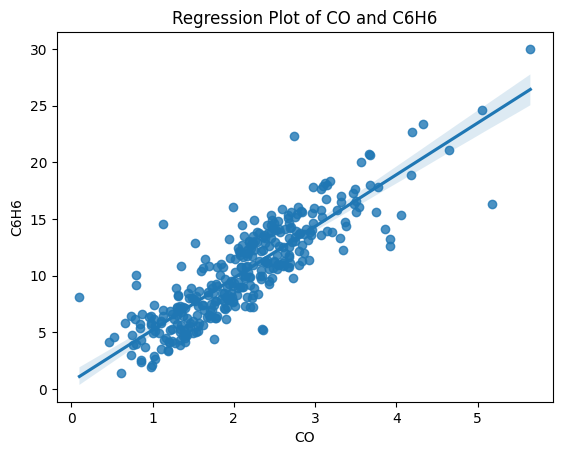

In [51]:
#Creating a regression plot of CO(GT) and C6H6(GT)
slr_plot = sns.regplot(x = daily_avg_df['CO(GT)'], y = daily_avg_df['C6H6(GT)'])
slr_plot.set_title('Regression Plot of CO and C6H6')
slr_plot.set_xlabel('CO')
slr_plot.set_ylabel('C6H6')

The pairplot below shows that no other variable has a relationship with C6H6 as strong as CO. Therefore, CO will be the only variable we will use in a simple regression line. We will use all of the variables in a multiple linear regression to see if it performs better or worse than the simple linear regression. To compare the models, we will use the Mean Square Error, MSE. The lower the MSE, the better the model predicts future values.

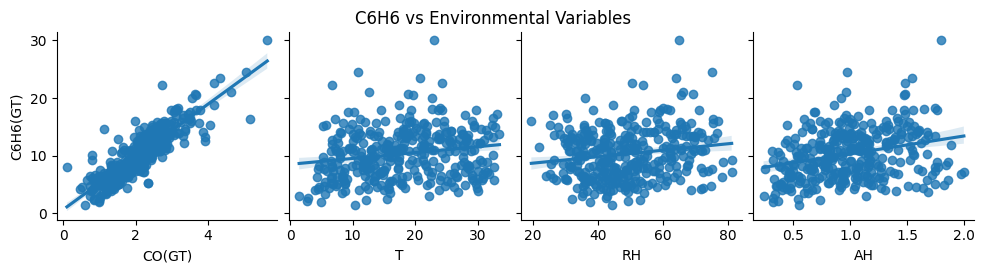

In [52]:
C6H6_graphs = sns.pairplot(
    data=daily_avg_df,
    y_vars=["C6H6(GT)"],
    x_vars=["CO(GT)", "T", "RH", "AH"],
    kind = 'reg'
)

C6H6_graphs.fig.suptitle("C6H6 vs Environmental Variables", y=1.05)
plt.show()

While temperature, relative humidity, and absolute humidity do show some positive association, it is very weak, and has no discernible form. CO would be the best single predictor for C6H6 out of this group of variables.

###SLR Model - C6H6 vs. CO

We will compare a model of using only CO to predict C6H6 against the a model that uses all of our varibles of interest to predict C6H6. Below we will determine the Mean Square Error of the simple linear regression of CO predicting C6H6.

In order to cacluate the MSE using test data, we need to have a pick a day to stop the training set of data, and begin our test set on the following day. We selected day 250. Using chronological data, we cannot calculuate the MSE the way that you might with non-chronological data. We will use the first 250 days of data to help test to see the accuracy of the regression in predicting the C6H6 of the 251st day. From this, we will calculate the Squared Error in this prediction.

Then, we will use the first 251 data points to help predict the 252nd day's C6H6 and calculate the Squared Error. This process will be repeated until we predict the final day. Once we have all of the squared errors, we average them to get the Mean Squared Error.

To get a step further, we will take the square root of the mean to get the `Root Mean Square Error`.

In [53]:
reg = linear_model.LinearRegression()

#Put the individual MSE's in a list so that you can search for a specific day if desired
MSE_list = []
start = 250
end = daily_avg_df.shape[0]


for current_day in range(start,end):
    x = daily_avg_df.loc[:current_day, 'CO(GT)'].values.reshape(-1,1)
    y = daily_avg_df.loc[:current_day, 'C6H6(GT)']

    #run fit and prediction
    reg.fit(x,y)
    pred = reg.predict(daily_avg_df.loc[current_day + 1, ['CO(GT)']].values.reshape(-1,1))

    #compute and print MSE
    MSE = metrics.mean_squared_error(daily_avg_df.loc[current_day + 1, ['C6H6(GT)']], pred)

    #Append daily MSE value to a list of MSE values.
    MSE_list.append(MSE)

#Average the MSE's over the list
average_MSE = sum(MSE_list)/(end - start)
print("The average daily MSE is " + str(average_MSE))
print("The average daily RMSE is " + str(average_MSE**0.5))

The average daily MSE is 7.4028972027687105
The average daily RMSE is 2.7208265660950737


The average MSE for predicting the next day using the first 250 days as a training set is approximately 7.40. Without context or something to compare it to, this value does not tell us much in terms of how well it predicts.

The root mean square error is approximately 2.72 in the same unit of measure of C6H6 as in the data.

Thanks to my colleauge, Jamie Loring, we did an extenstive dive into the C6H6 variable in Task 2, we know that the mean C6H6 level is 10.08. Therefore, the Coefficiation of Variation for C6H6 would be $\frac{2.72}{10.08}=0.27$ This means that the typical error in prediction using this model is about 27% of the average.

Using Jamie's findings, it would be better to use the median (8.2) to discuss the typical C6H6 value. While there is not a mean metric for using the median with the RMSE, we will create and interpret one here.

$\frac{2.72}{8.2}=0.33$ This means that the typical prediction error is 33% of the median C6H6. Given, that it could be above or below the median, this gives us a very wide range from predicting C6H6 based off of a new value of CO. We need to investigate the Multiple Linear Regression model to see if it would produce better predictions.

###MLR Model

Now we will construct a  Multiple Linear Regression model to predict C6H6 from our other variables of interest. We use a similar approach here to determine the Mean Square Error. Comparing the MSE or RMSE of both models will give us evidence towards which model we should select.

In [54]:
MLR_reg = linear_model.LinearRegression()

#Put the individual MSE's in a list so that you can search for a specific day if desired
MLR_MSE_list = []
start = 250
end = daily_avg_df.shape[0]

for current_day in range(start,end):
    x = daily_avg_df.loc[:current_day, ['CO(GT)', 'T', 'RH', 'AH']]
    y = daily_avg_df.loc[:current_day, 'C6H6(GT)']

    #run fit and prediction
    MLR_reg.fit(x,y)
    MLR_pred = MLR_reg.predict(daily_avg_df.loc[[current_day + 1], ['CO(GT)', 'T', 'RH', 'AH']])

    #Print daily predicition and actual value
    #print("Prediction for day " + str(current_day + 1) + " is " + str(MLR_pred[0]))
    #print("Actual value for day " + str(current_day + 1) + " is " + str(daily_avg_df.loc[current_day + 1, 'C6H6(GT)']))

    #compute and print MSE
    MLR_MSE = metrics.mean_squared_error(daily_avg_df.loc[current_day + 1, ['C6H6(GT)']], MLR_pred)
    #print("MSE for day " + str(current_day + 1) + " is " + str(MLR_MSE) + "\n")

    #Append daily MSE value to a list of MSE values.
    MLR_MSE_list.append(MLR_MSE)

#Sum up all MSE values to calculate the actual MSE of the prediction
MLR_sum_MSE = sum(MLR_MSE_list)/(end - start)
print("The daily MSE is " + str(MLR_sum_MSE))
print("The daily RMSE is " + str(MLR_sum_MSE**0.5))

The daily MSE is 5.096311564583979
The daily RMSE is 2.257501177094705


The MSE is approximately 5.10, while the RMSE is approximately 2.26.  These values are lower than the MSE and RMSE of the simple regression model we used above (7.0 and 2.72, respectively). This means that the predictions using the Multiple Linear Regression model were more accurate on average than the Simple Linear Regression model.

However, the RMSE values are not terribly different from each other. The difference between the two models could be due to the training data. We arbitrary started at day 250 to build our model. We could test this using different starting days to see if the Multiple Linear Regression model would continue to have the lower MSE and RMSE no matter the starting day.

###MSE function

In order to accomplish the task of comparing the models using different starting days - and to apply this to other chronologically ordered data - we want to be a function to calculate the MSE and RMSE.

Below is the function `current_MSE_time` that will calculate the squared error for the prediction for the next day.  This is a helper function to help us calculate the MSE and RMSE for multiple days.

The function `MSU_time` returns the MSE for the predictions of all of the days following the start day. This is the approach to calculate the MSE in the previous section.

In [66]:
def current_MSE_time(X, y, day):
    '''
    This function will take a data frame of predictors for the X arg, and a 1D response
    as the y arg. The day arg is the last day that should be used for the training set
    of the data. This will only give  the MSE and RMSE for next day.
    '''
    #subset the data for the training set
    _x = X.loc[:day]
    _y = y.loc[:day]
    reg = linear_model.LinearRegression()
    reg.fit(_x,_y)

    #predict using the test set (the next day)
    pred = reg.predict(X.loc[[day + 1]])

    #determine the Mean Square Error for the prediction of the next day
    daily_MSE = metrics.mean_squared_error([y.loc[day + 1]], pred)
    return daily_MSE


def MSE_time(X, y, day):
    '''
    This function will take a data frame of predictors for the X arg, and a 1D response
    as the y arg. The day arg is the last day that should be used for the training set
    of the data. This will sum the MSE and RMSE for the entire test set.
    '''
    #Start with a MSE of 0
    sum_MSE = 0

    #Determine the last day of the dataset
    end = X.shape[0]

    #Run for loop for each day from start to the day before the last day
    for current_day in range(day,end):
        sum_MSE += current_MSE_time(X = X, y = y, day = current_day)

    MSE = sum_MSE / (end - day)
    #Return the sum of the daily MSE.
    return MSE

In [67]:
MSE_time(X = daily_avg_df[['CO(GT)']], y = daily_avg_df['C6H6(GT)'], day = 250)

7.402897202768712

In [68]:
MSE_time(X = daily_avg_df[['CO(GT)', 'T', 'RH', 'AH']], y = daily_avg_df['C6H6(GT)'], day = 250)

5.096311564583978

To test our function, we ran the code to produce the MSE of the two models as recorded above. The correct MSE for each model was produced.

Out of curiousity, we wanted to run the code starting at day 1 to see what the results would be.

In [69]:
MSE_time(X = daily_avg_df[['CO(GT)']], y = daily_avg_df['C6H6(GT)'], day = 1)

4.952910911002804

In [70]:
MSE_time(X = daily_avg_df[['CO(GT)', 'T', 'RH', 'AH']], y = daily_avg_df['C6H6(GT)'], day = 1)

3.6054013278652866

When starting at day 1, the MSE of the MLR model was still lower than the MSE of the SLR model. We are confident that the MLR is a slightly better predictor than the SLR for C6H6.

In future studies, I would like to see if these results would hold for any day from day 1 to day 347.

###Conclusion

Based on the MSE values of 7.4029 and 5.0963 , we would select the multiple-linear-regression model due to the much lower MSE.

In [60]:
true_reg = linear_model.LinearRegression()
true_reg.fit(daily_avg_df[['CO(GT)', 'T', 'RH', 'AH']], daily_avg_df['C6H6(GT)'])

print(true_reg.coef_)
print(true_reg.intercept_)

[ 4.77080433  0.11973259 -0.01620259  0.68866811]
-1.8377694729981755


Using all of the data now to fit our model, we get the following:

```
C6H6(GT)_hat = -1.8377 + 4.7708*CO(GT) + 0.1197*T - 0.0162*RH + 0.6887*AH
```

Based on the slopes, CO(GT) has the most impact on predicting C6H6(GT), but the additional variables give us a bitter prediction on average.  The slope for RH is negative, which is interesting given the scatterplot of C6H6 vs. RH above.

In [61]:
MSE_time(X = daily_avg_df[['CO(GT)', 'T', 'AH']], y = daily_avg_df['C6H6(GT)'], day = 250)

The average of the daily MSE is 5.045048424533974


5.045048424533974

As expected, when the the RH variable was removed from the list of predictors of C6H6, we actually love the MSE a bit. The code below gives the MSE using any combination of predictors out of the four variables we were interested in using to predict C6H6.

In [76]:
from itertools import combinations

original_vars = ['CO(GT)', 'T', 'RH', 'AH']

for r in range(1, len(original_vars) + 1):
    for combo in combinations(original_vars, r):
        result = MSE_time(X = daily_avg_df[list(combo)], y = daily_avg_df['C6H6(GT)'], day = 250)
        print("predictor(s) " + str(list(combo)) + " produce(s) a MSE of " + str(result))

predictor(s) ['CO(GT)'] produce(s) a MSE of 7.402897202768712
predictor(s) ['T'] produce(s) a MSE of 16.464001016024152
predictor(s) ['RH'] produce(s) a MSE of 18.689746523123386
predictor(s) ['AH'] produce(s) a MSE of 14.729562592929044
predictor(s) ['CO(GT)', 'T'] produce(s) a MSE of 5.031566362258851
predictor(s) ['CO(GT)', 'RH'] produce(s) a MSE of 7.341379662286379
predictor(s) ['CO(GT)', 'AH'] produce(s) a MSE of 5.160786863899962
predictor(s) ['T', 'RH'] produce(s) a MSE of 13.982757745545234
predictor(s) ['T', 'AH'] produce(s) a MSE of 15.224629279755092
predictor(s) ['RH', 'AH'] produce(s) a MSE of 14.95516888087832
predictor(s) ['CO(GT)', 'T', 'RH'] produce(s) a MSE of 5.06878466346805
predictor(s) ['CO(GT)', 'T', 'AH'] produce(s) a MSE of 5.045048424533974
predictor(s) ['CO(GT)', 'RH', 'AH'] produce(s) a MSE of 5.167971705497675
predictor(s) ['T', 'RH', 'AH'] produce(s) a MSE of 14.241090246203482
predictor(s) ['CO(GT)', 'T', 'RH', 'AH'] produce(s) a MSE of 5.096311564583978

From this, we can see that the lowest given MSE is from using CO and temperature to predict the C6H6 quantity. We also see that any combination that does not include CO is much worse than any model that uses CO.

Additional Study:


*   Look at MSE of other variables not used in this study to see how they compare to the MSE of using CO(GT) to predict C6H6(GT).
*   Try using interaction variables to see if they change the model.
*   While, not given in our data, interest is shown in how the current precipiation amount changes the quantity of C6H6(GT). An indicator varible based on if it is raining or not may reveal other trends.
*   As alluded to in Task 2, the season or month may also make an impact on predicting the C6H6 quantity.